# Introduction

Over the course of the month, I have learnt a lot about transformers and pytorch. During one such lesson, I stumbled across Pytorch-lightning and how it can create a general framework for the pytorch deep learning model that we are building. 
Keeping that in mind, I set across learning about how to structure regular pytorch code into lightning code. This is one such attempt at that, with WanDB to showcase the ML-OPS part of the training. 

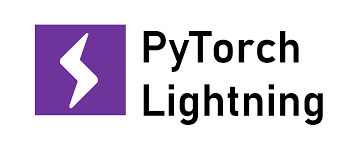

Also, over the course of a lot of learning, I realised that most of the tutorials that can be found easily on the web generally use a prepackaged model such as BertSequenceClassification, this made it difficult to figure out where the _forward_ step should go, or where the linear layers should have gone. Overcoming that obstacle was the main challenge of this notebook, along with finding a way to fit the model on Kaggle's less optimal memory provision. 

Thus, this notebook highlights upon: 
1. Use of custom model (XLM Roberta) with pytorch lightning. 
2. Weights and Biases to showcase the ML-OPS




# Note: 
The model building aspect was taken from: 
- https://www.kaggle.com/rhtsingh/chaii-qa-5-fold-xlmroberta-torch-fit

Give Torch an upvote for his tremendous baseline code, as that allowed me to write the code for this. 

# Installing and Importing Libraries

Since we are also exploring Wandb, initializing that

In [ ]:
import wandb
from pytorch_lightning.loggers import WandbLogger

wandb.login()

Installing pytorch lightning and torch to a newer version as torch 1.7.0 has an error while training with lightning. 

In [ ]:
!pip install  torch==1.7.1 --quiet
!pip install pytorch_lightning==1.4.5 --quiet

In [ ]:
# Helper libraries
import os
import gc
gc.enable()
import math
import json
import time
import random
import multiprocessing
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from sklearn import model_selection
from collections import OrderedDict

#Pytorch, transformers
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Parameter
import torch.optim as optim
from torch.utils.data import (
    Dataset, DataLoader,
    SequentialSampler, RandomSampler
)
from torch.utils.data.distributed import DistributedSampler

try:
    from apex import amp
    APEX_INSTALLED = True
except ImportError:
    APEX_INSTALLED = False

import transformers
from transformers import (
    WEIGHTS_NAME,
    AdamW,
    AutoConfig,
    AutoModel,
    AutoTokenizer,
    get_cosine_schedule_with_warmup,
    get_linear_schedule_with_warmup,
    logging,
    MODEL_FOR_QUESTION_ANSWERING_MAPPING,
)
logging.set_verbosity_warning()
logging.set_verbosity_error()


#Import pytorch lightning: 
import pytorch_lightning as pl
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning import Callback
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.callbacks import LearningRateMonitor

print(f"Apex AMP Installed :: {APEX_INSTALLED}")
MODEL_CONFIG_CLASSES = list(MODEL_FOR_QUESTION_ANSWERING_MAPPING.keys())
MODEL_TYPES = tuple(conf.model_type for conf in MODEL_CONFIG_CLASSES)

# Loading data

In [ ]:
train = pd.read_csv('../input/chaii-hindi-and-tamil-question-answering/train.csv')
test = pd.read_csv('../input/chaii-hindi-and-tamil-question-answering/test.csv')
external_mlqa = pd.read_csv('../input/mlqa-hindi-processed/mlqa_hindi.csv')
external_xquad = pd.read_csv('../input/mlqa-hindi-processed/xquad.csv')
external_train = pd.concat([external_mlqa, external_xquad])

# Necessary Functions

The index of necessary functions in order: 
- **create_folds**: Kfold data prep
- **fix_all_seeds**: Allows us to reproduce it: Code from: https://www.kaggle.com/rhtsingh/chaii-qa-5-fold-xlmroberta-torch-fit
- **optimal_num_of_loader_workers**: Find the optimal number of workers based on config. Code from: https://www.kaggle.com/rhtsingh/chaii-qa-5-fold-xlmroberta-torch-fit

In [ ]:
def create_folds(data, num_splits):
    '''
        This function is used for creating the folds for k-fold splits
        
        Args: 
            - data: Dataframe
            - num_splits: int: Number of splits needed
        
        Returns: 
            - df_fold: Dataframe with folds
    '''
    
    # we create a new column called kfold and fill it with -1
    data["kfold"] = -1
    
    # the next step is to randomize the rows of the data
    data = data.sample(frac=1).reset_index(drop=True)

 
    # initiate the kfold class from model_selection module
    kf = model_selection.StratifiedKFold(n_splits=num_splits, random_state=42, shuffle=True)
    
    for f, (t_, v_) in enumerate(kf.split(X=data, y=data['language'])):
        data.loc[v_, 'kfold'] = f

    # return dataframe with folds
    return data

In [ ]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    


def optimal_num_of_loader_workers():
    num_cpus = multiprocessing.cpu_count()
    num_gpus = torch.cuda.device_count()
    optimal_value = min(num_cpus, num_gpus*4) if num_gpus else num_cpus - 1
    return optimal_value


# Preparing Data: 

In [ ]:
# Necessary helper function: 

def convert_answers(row):
    return {'answer_start': [row[0]], 'text': [row[1]]}


In [ ]:
train = create_folds(train, num_splits=5)
external_train["kfold"] = -1
external_train['id'] = list(np.arange(1, len(external_train)+1))
df = pd.concat([train, external_train]).reset_index(drop=True)

df['answers'] = df[['answer_start', 'answer_text']].apply(convert_answers, axis=1)

# Defining Configuration

In [ ]:
class Config():
    # model
    model_type = 'xlm_roberta'
    model_name_or_path = "deepset/xlm-roberta-base-squad2"
    config_name = "deepset/xlm-roberta-base-squad2"
    fp16 = True if APEX_INSTALLED else False
    fp16_opt_level = "O1"
    gradient_accumulation_steps = 2

    # tokenizer
    tokenizer_name = "deepset/xlm-roberta-base-squad2"
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
    max_seq_length = 384
    doc_stride = 128

    # train
    epochs = 1
    train_batch_size = 1
    eval_batch_size = 1

    # optimizer
    optimizer_type = 'AdamW'
    learning_rate = 1.5e-5
    weight_decay = 1e-2
    epsilon = 1e-8
    max_grad_norm = 1.0

    # scheduler
    decay_name = 'linear-warmup'
    warmup_ratio = 0.1

    # logging
    logging_steps = 10

    # evaluate
    output_dir = 'output'
    seed = 42

In [ ]:
args = Config()
tokenizer = args.tokenizer

# Dataset class and Dataloader

In [ ]:
def prepare_train_features(example):
    tokenizer = args.tokenizer
    example["question"] = example["question"].lstrip()
    tokenized_example = tokenizer(
        example["question"],
        example["context"],
        truncation="only_second",
        max_length=args.max_seq_length,
        stride=args.doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    sample_mapping = tokenized_example.pop("overflow_to_sample_mapping")
    offset_mapping = tokenized_example.pop("offset_mapping")

    features = []
    for i, offsets in enumerate(offset_mapping):
        feature = {}

        input_ids = tokenized_example["input_ids"][i]
        attention_mask = tokenized_example["attention_mask"][i]

        feature['input_ids'] = input_ids
        feature['attention_mask'] = attention_mask
        feature['offset_mapping'] = offsets

        cls_index = input_ids.index(tokenizer.cls_token_id)
        sequence_ids = tokenized_example.sequence_ids(i)

        sample_index = sample_mapping[i]
        answers = example["answers"]

        if len(answers["answer_start"]) == 0:
            feature["start_position"] = cls_index
            feature["end_position"] = cls_index
        else:
            start_char = answers["answer_start"][0]
            end_char = start_char + len(answers["text"][0])

            token_start_index = 0
            while sequence_ids[token_start_index] != 1:
                token_start_index += 1

            token_end_index = len(input_ids) - 1
            while sequence_ids[token_end_index] != 1:
                token_end_index -= 1

            if not (offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char):
                feature["start_position"] = cls_index
                feature["end_position"] = cls_index
            else:
                while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
                    token_start_index += 1
                feature["start_position"] = token_start_index - 1
                while offsets[token_end_index][1] >= end_char:
                    token_end_index -= 1
                feature["end_position"] = token_end_index + 1

        features.append(feature)
    return features


def make_loader(  fold
):
    train_set, valid_set = df[df['kfold']!=fold], df[df['kfold']==fold]
    
    train_features, valid_features = [[] for _ in range(2)]
    for i, row in train_set.iterrows():
        train_features += prepare_train_features(row)
    for i, row in valid_set.iterrows():
        valid_features += prepare_train_features( row)

    train_dataset = DatasetRetriever(train_features)
    valid_dataset = DatasetRetriever(valid_features)
    print(f"Num examples Train= {len(train_dataset)}, Num examples Valid={len(valid_dataset)}")
    
    train_sampler = RandomSampler(train_dataset)
    valid_sampler = SequentialSampler(valid_dataset)

    train_dataloader = DataLoader(
        train_dataset,
        batch_size=args.train_batch_size,
        sampler=train_sampler,
        num_workers=optimal_num_of_loader_workers(),
        pin_memory=True,
        drop_last=False 
    )

    valid_dataloader = DataLoader(
        valid_dataset,
        batch_size=args.eval_batch_size, 
        sampler=valid_sampler,
        num_workers=optimal_num_of_loader_workers(),
        pin_memory=True, 
        drop_last=False
    )

    return train_dataloader, valid_dataloader

In [ ]:
class DatasetRetriever(Dataset):
    def __init__(self, features, mode='train'):
        super(DatasetRetriever, self).__init__()
        self.features = features
        self.mode = mode
        
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, item):   
        feature = self.features[item]
        if self.mode == 'train':
            return {
                'input_ids':torch.tensor(feature['input_ids'], dtype=torch.long),
                'attention_mask':torch.tensor(feature['attention_mask'], dtype=torch.long),
                'offset_mapping':torch.tensor(feature['offset_mapping'], dtype=torch.long),
                'start_position':torch.tensor(feature['start_position'], dtype=torch.long),
                'end_position':torch.tensor(feature['end_position'], dtype=torch.long)
            }
        else:
            return {
                'input_ids':torch.tensor(feature['input_ids'], dtype=torch.long),
                'attention_mask':torch.tensor(feature['attention_mask'], dtype=torch.long),
                'offset_mapping':feature['offset_mapping'],
                'sequence_ids':feature['sequence_ids'],
                'id':feature['example_id'],
                'context': feature['context'],
                'question': feature['question']
            }

# Defining the model with pytorch lightning


In [ ]:
def loss_fn(preds, labels):
    start_preds, end_preds = preds
    start_labels, end_labels = labels
    start_loss = nn.CrossEntropyLoss(ignore_index=-1)(start_preds, start_labels)
    end_loss = nn.CrossEntropyLoss(ignore_index=-1)(end_preds, end_labels)
    total_loss = (start_loss + end_loss) / 2
    return total_loss

In [ ]:
class Model(pl.LightningModule):
    
    def __init__(self, fold):
        super(Model, self).__init__()
        self.config = args
        self.model_config = AutoConfig.from_pretrained(self.config.config_name)
        self.model = AutoModel.from_pretrained(self.config.model_name_or_path, config=self.model_config)
        self.qa_outputs = nn.Linear(self.model_config.hidden_size, 2)
        self.dropout = nn.Dropout(self.model_config.hidden_dropout_prob)
        self._init_weights(self.qa_outputs)
        
        train_dataloader, val_dataloader= make_loader(fold)
        
        self._train_dataloader = train_dataloader
        self._val_dataloader = val_dataloader
        self.all_targets=[]
        self.all_preds=[]
        self.train_loss=0
        self.val_loss=0
        self.t_data_size=0
        self.v_data_size=0
        self.automatic_optimization = True
        
    
    
    def forward(self, input_ids, attention_mask ):
        '''
            The forward step performs the next step for the model while training. 
        '''
    
        outputs = self.model(
            input_ids,
            attention_mask=attention_mask,
        )

        sequence_output = outputs[0]
        pooled_output = outputs[1]
        
        # sequence_output = self.dropout(sequence_output)
        qa_logits = self.qa_outputs(sequence_output)
        
        start_logits, end_logits = qa_logits.split(1, dim=-1)
        start_logits = start_logits.squeeze(-1)
        end_logits = end_logits.squeeze(-1)
    
        return start_logits, end_logits
        
    
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.model_config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()

        
    def configure_optimizers(self):
        param_optimizer = list(self.model.named_parameters())
        no_decay = ["bias", "LayerNorm.weight",]
        optimizer_grouped_parameters = [
                {
                    "params": [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
                    "weight_decay_rate": self.config.weight_decay
                    },
                {
                    "params": [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
                    "weight_decay_rate": 0.0
                    },
                ]
        optimizer = AdamW(
                optimizer_grouped_parameters,
                lr=self.config.learning_rate,
                eps = self.config.epsilon,
                correct_bias=True
                )
        

        # Defining LR Scheduler
        
        
        self.num_training_steps= len(self._train_dataloader)*self.config.epochs
        self.num_warmup_steps= self.num_training_steps * self.config.warmup_ratio
        
        scheduler = get_linear_schedule_with_warmup( optimizer, \
                            num_warmup_steps = self.num_warmup_steps, num_training_steps= self.num_training_steps)
        
        
        self.scheduler=scheduler
        self.optimizer=optimizer
        
        return {
            'optimizer': self.optimizer,
            'lr_scheduler': {
                'scheduler': self.scheduler,
                'monitor': 'val_loss',
            }
        }
    
    
    def training_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        targets_start = batch["start_position"]
        targets_end = batch['end_position']
        
        
        '''
            NOTE: Pass the data to self(param1, param2) instead of self.model(param1, param2) as this allows data to return in tensor format to the loss function, instead of strings. 
            This was a critical point, as without this, there were continuous errors to get the loss function working. 
        '''
        outputs_start, outputs_end = self(
                input_ids,
                attention_mask=attention_mask
                )
        
       
        
        loss = loss_fn((outputs_start, outputs_end), (targets_start, targets_end))
    
        
        self.train_loss +=(loss.item() * input_ids.size(0))
        self.t_data_size+= input_ids.size(0)
        
        epoch_loss=self.train_loss/self.t_data_size
        self.log('train_loss', epoch_loss, on_epoch=True, prog_bar=True, logger=True)
        tqdm_dict={'train_loss':loss}
        self.scheduler.step()
        self.optimizer.zero_grad()
        
        output = OrderedDict({
            "loss": loss,
            "progress_bar": tqdm_dict,
            "log": tqdm_dict
            })

        return output
    
    
    def validation_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        targets_start = batch["start_position"]
        targets_end = batch['end_position']
        
        #Note: Same as training step, pass to self instead of self.model
        outputs_start, outputs_end = self(
                input_ids,
                attention_mask=attention_mask
                )
        
        loss = loss_fn((outputs_start, outputs_end), (targets_start, targets_end))
        
        self.val_loss +=(loss.item() * input_ids.size(0))
        self.v_data_size+=input_ids.size(0)
        
        epoch_loss=self.val_loss/self.v_data_size
        
        logs = {
            "val_loss": epoch_loss,
        }

        
        self.log_dict(logs, on_epoch=True, prog_bar=True, logger=True)
        
        output = OrderedDict({
            "val_loss": loss,
            })
        return output
    
    def validation_end(self, outputs):
        val_loss = sum([out["val_loss"] for out in outputs]) / len(outputs)
        result = {"progress_bar": tqdm_dict, "log": tqdm_dict, "val_loss": val_loss}
        return result
   
    def train_dataloader(self):
        return self._train_dataloader

    def val_dataloader(self):
        return self._val_dataloader


In [ ]:
lr_monitor = LearningRateMonitor(logging_interval='step')
# Checkpoint
checkpoint_callback = ModelCheckpoint(monitor='val_loss',
                                      save_top_k=1,
                                      save_last=True,
                                      save_weights_only=True,
                                      filename='checkpoint/{epoch:02d}-{val_loss:.4f}',
                                      verbose=False,
                                      mode='min')

# Earlystopping
earlystopping = EarlyStopping(monitor='val_loss', patience=5, mode='min')

# Run Model with Pytorch lightning and evaluate with WanDB

In [ ]:
#fold1 train
for fold in range(1):
    print();print()
    print('-'*50)
    print(f'FOLD: {fold}')
   
    model = Model(fold)
    # instrument experiment with W&B
    wandb_logger = WandbLogger(project='Chaii_QA', log_model='all',job_type='train')
    trainer = pl.Trainer(logger=wandb_logger,max_epochs=args.epochs,callbacks=[earlystopping,lr_monitor, checkpoint_callback],checkpoint_callback=True, gpus=1, accumulate_grad_batches=2)
    # log gradients and model topology
    wandb_logger.watch(model)
    trainer.fit(model)
    wandb.finish()
    print('-'*50)

All of this training was done with XLM-Roberta-Base, as that fit easily into the GPU reuirements for Kaggle. This notebook was trained on just one fold to showcase the way a pytorch lighning framework can be used for the quesiton answering task. The same can also be modified to use for any particular task need. 



# W&B Outputs

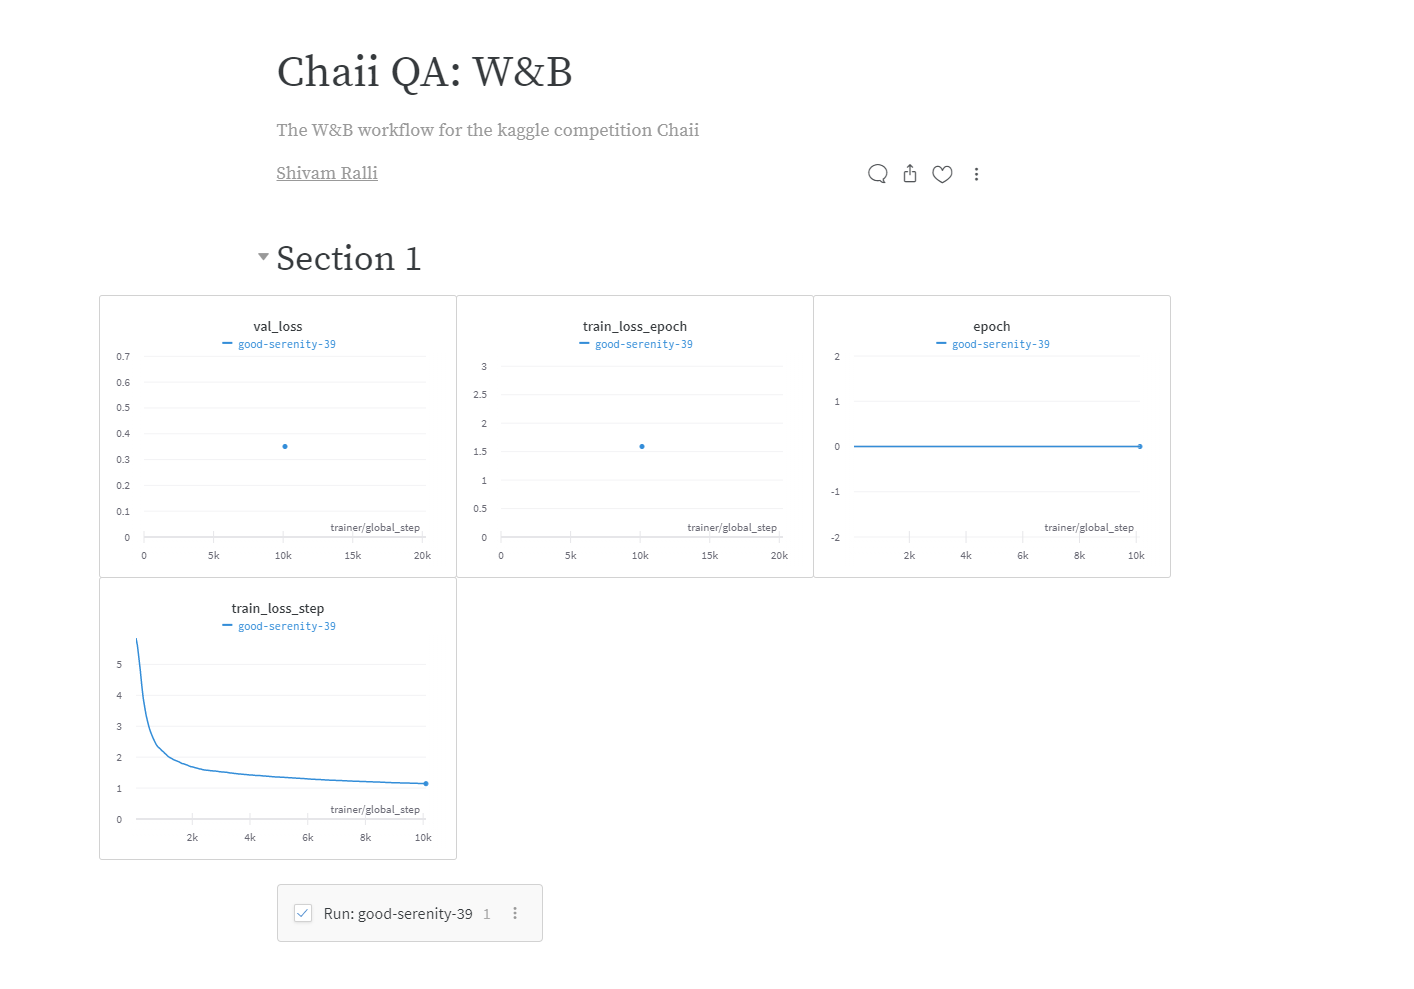

See the report at: https://wandb.ai/sralli/Chaii_QA/reports/Chaii-QA-W-B---VmlldzoxMDA1OTUz?accessToken=5f30ug11tuv0ze1w2zccmya0izaalhjd3a1hs7vdzq5bt4b6auakrqospelbo2rn



If you found this useful, please consider upvoting. Drop a comment if there are some potential tricks to optimise the model better. Thanks a lot! 